# Field sampling tutorial

The particle trajectories allow us to study fields like temperature, plastic concentration or chlorophyll from a Lagrangian perspective. 

In this tutorial we will go through how particles can sample `Fields`, using temperature as an example. Along the way we will get to know the parcels class `Variable` (see [here](https://oceanparcels.org/gh-pages/html/#parcels.particle.Variable) for the documentation) and some of its methods. We import the `Variable` class as well as the standard modules needed to set up a simulation.

In [1]:
# Modules needed for the Parcels simulation
from parcels import Variable, FieldSet, ParticleSet, JITParticle, AdvectionRK4
import numpy as np
from datetime import timedelta as delta

# To open and look at the temperature data
import xarray as xr 
import matplotlib as mpl
import matplotlib.pyplot as plt

Suppose we want to study the environmental temperature for plankton drifting around a peninsula. We have a dataset with surface ocean velocities and the corresponding sea surface temperature stored in netcdf files in the folder `"Peninsula_data"`. Besides the velocity fields, we load the temperature field using `extra_fields={'T': 'T'}`. The particles are released on the left hand side of the domain.

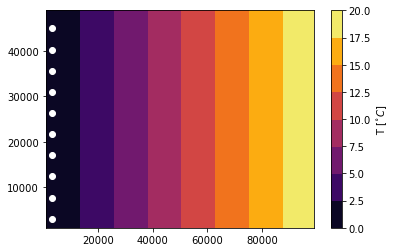

In [2]:
# Velocity and temperature fields
fieldset = FieldSet.from_parcels("Peninsula_data/peninsula", extra_fields={'T': 'T'}, allow_time_extrapolation=True)

# Particle locations and initial time
npart = 10  # number of particles to be released
lon = 3e3 * np.ones(npart)
lat = np.linspace(3e3 , 45e3, npart, dtype=np.float32)
time = np.arange(0, npart) * delta(hours=2).total_seconds()  # release each particle two hours later

# Plot temperature field and initial particle locations
T_data = xr.open_dataset("Peninsula_data/peninsulaT.nc")
plt.figure()
ax = plt.axes()
T_contour = ax.contourf(T_data.x.values, T_data.y.values, T_data.T.values[0,0], cmap=plt.cm.inferno)
ax.scatter(lon, lat, c='w')
plt.colorbar(T_contour, label='T [$^{\circ} C$]')
plt.show()

To sample the temperature field, we need to create a new class of particles where temperature is a `Variable`. As an argument for the `Variable` class, we need to provide the initial values for the particles. The easiest option is to access `fieldset.T`, but this option has some drawbacks.

In [3]:
class SampleParticle(JITParticle):         # Define a new particle class
    temperature = Variable('temperature', initial=fieldset.T)  # Variable 'temperature' initialised by sampling the temperature

pset = ParticleSet(fieldset=fieldset, pclass=SampleParticle, lon=lon, lat=lat, time=time)

Using `fieldset.T` leads to the `WARNING` displayed above because `Variable` accesses the fieldset in the slower SciPy mode. Another problem can occur when using the repeatdt argument instead of time:

<a id='repeatdt_error'></a>

In [9]:
repeatdt = delta(hours=3)

pset = ParticleSet(fieldset=fieldset, pclass=SampleParticle, lon=lon, lat=lat, repeatdt=repeatdt)

SyntaxError: invalid syntax (<ipython-input-9-bbf54c551b12>, line 4)

Since the initial time is not defined, the `Variable` class does not know at what time to access the temperature field.

The solution to this initialisation problem is to leave the initial value zero and sample the initial condition in JIT mode with the sampling Kernel:

In [3]:
class SampleParticleInitZero(JITParticle):         # Define a new particle class
    temperature = Variable('temperature', initial=0)  # Variable 'temperature' initially zero

pset = ParticleSet(fieldset=fieldset, pclass=SampleParticleInitZero, lon=lon, lat=lat, time=time)

def SampleT(particle, fieldset, time):
         particle.temperature = fieldset.T[time, particle.depth, particle.lat, particle.lon]
sample_kernel = pset.Kernel(SampleT)    # Casting the SampleT function to a kernel.

To sample the initial values we can execute the Sample kernel over the entire particleset with dt = 0 so that time does not increase

In [4]:
pset.execute(sample_kernel, dt=0) # by only executing the sample kernel we record the initial temperature of the particles

output_file = pset.ParticleFile(name="InitZero.nc", outputdt=delta(hours=1))
pset.execute(AdvectionRK4 + sample_kernel, runtime=delta(hours=30), dt=delta(minutes=5),
             output_file=output_file)
output_file.export()  # export the trajectory data to a netcdf file
output_file.close()

INFO: Compiled SampleParticleInitZeroSampleT ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\408092689f7e93ea51e69b2c866a4f62_0.dll
INFO: Compiled SampleParticleInitZeroAdvectionRK4SampleT ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\79e8e576dd341aa63ba6603c9cc85ca4_0.dll


The particle dataset now contains the particle trajectories and the corresponding environmental temperature

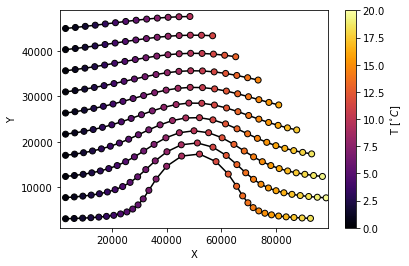

In [5]:
Particle_data = xr.open_dataset("InitZero.nc")

plt.figure()
ax = plt.axes()
ax.set_ylabel('Y')
ax.set_xlabel('X')
ax.set_ylim(1000, 49000)
ax.set_xlim(1000, 99000)
ax.plot(Particle_data.lon.transpose(), Particle_data.lat.transpose(), c='k', zorder=1)
T_scatter = ax.scatter(Particle_data.lon, Particle_data.lat, c=Particle_data.temperature, 
                       cmap=plt.cm.inferno, norm=mpl.colors.Normalize(vmin=0., vmax=20.), 
                       edgecolor='k', zorder=2)
plt.colorbar(T_scatter, label='T [$^{\circ} C$]')
plt.show()

### Sampling initial values

In some simulations only the particles initial value within the field is of interest: the variable does not need to be known along the entire trajectory. To reduce computing we can specify the `to_write` argument to the temperature `Variable`. This argument can have three values: `True`, `False` or `'once'`. It determines whether to write the `Variable` to the output file. If we want to know only the initial value, we can enter `'once'` and only the first value will be written to the output file.

In [6]:
class SampleParticleOnce(JITParticle):         # Define a new particle class
    temperature = Variable('temperature', initial=0, to_write='once')  # Variable 'temperature'
    
pset = ParticleSet(fieldset=fieldset, pclass=SampleParticleOnce, lon=lon, lat=lat, time=time)

In [7]:
pset.execute(sample_kernel, dt=0) # by only executing the sample kernel we record the initial temperature of the particles

output_file = pset.ParticleFile(name="WriteOnce.nc", outputdt=delta(hours=1))
pset.execute(AdvectionRK4, runtime=delta(hours=24), dt=delta(minutes=5),
             output_file=output_file)
output_file.close()

INFO: Compiled SampleParticleInitZeroSampleT ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\b5170f3404778a7fe8fd60b0201df91b_0.dll
INFO: Compiled SampleParticleOnceAdvectionRK4 ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\a6593fd5b195ea1ec75a73fcfc3b8c16_0.dll


Since all the particles are released at the same x-position and the temperature field is invariant in the y-direction, all particles have an initial temperature of 0.4$^\circ$C

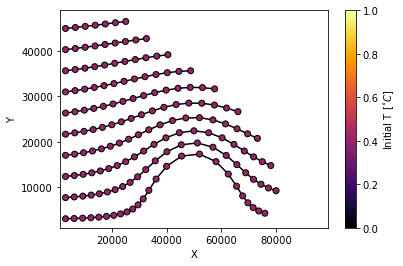

In [8]:
Particle_data = xr.open_dataset("WriteOnce.nc")

plt.figure()
ax = plt.axes()
ax.set_ylabel('Y')
ax.set_xlabel('X')
ax.set_ylim(1000, 49000)
ax.set_xlim(1000, 99000)
ax.plot(Particle_data.lon.transpose(), Particle_data.lat.transpose(), c='k', zorder=1)
T_scatter = ax.scatter(Particle_data.lon, Particle_data.lat, 
                       c=np.tile(Particle_data.temperature, (Particle_data.lon.shape[1], 1)).T,
                       cmap=plt.cm.inferno, norm=mpl.colors.Normalize(vmin=0., vmax=1.), 
                       edgecolor='k', zorder=2)
plt.colorbar(T_scatter, label='Initial T [$^{\circ} C$]')
plt.show()

#### Sampling with repeatdt



Some experiments require large sets of particles to be released repeatedly on the same locations. The parcels [`particleset`](https://oceanparcels.org/gh-pages/html/#module-parcels.particleset) has the option `repeatdt` for this but when you want to sample the initial values this introduces some problems as we have seen [here](#repeatdt_error). Executing a particleset with the repeatdt argument also results in not all particle trajectories being the same length, as some particles are released later and the runtime is of a finite length. In these cases it makes more sense to execute the different sets separately in a simple for loop and store the output in the same file. In this way, we can store the initial values in the same way we did before.

In [12]:
time = np.zeros(npart)                    # release all particles of the set at the same time
repeatdt = delta(hours=2).total_seconds() # release each set of particles two hours later
repeatx = 10                              # amount of times to release the particleset

output_file = pset.ParticleFile(name="RepeatLoop.nc", outputdt=delta(hours=1))

for i in range(repeatx):
    pset = ParticleSet(fieldset=fieldset, pclass=SampleParticleOnce, lon=lon, lat=lat, time=time) # Using SampleParticleOnce, which only writes one temperature value to the output file
    
    pset.execute(sample_kernel, dt=0) # by only executing the sample kernel we record the initial temperature of the particles

    pset.execute(AdvectionRK4, runtime=delta(hours=24), dt=delta(minutes=5), output_file=output_file)
    
    time += repeatdt # 

output_file.export()

INFO: Compiled SampleParticleInitZeroSampleT ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\f32ccf67c1d16c35f114555addf2c0cc_0.dll
INFO: Compiled SampleParticleOnceAdvectionRK4 ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\dd0ef95a9540095c23f757d628b36d6a_0.dll
INFO: Compiled SampleParticleInitZeroSampleT ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\591f83c27a294ad1137bde98d9ec978c_0.dll
INFO: Compiled SampleParticleOnceAdvectionRK4 ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\3201536ff4627934622187eb31f491f6_0.dll
INFO: Compiled SampleParticleInitZeroSampleT ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\5fec857b9bf3381be666550659e982ea_0.dll
INFO: Compiled SampleParticleOnceAdvectionRK4 ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\edd6f0f26d523cbf06019ba930e7176b_0.dll
INFO: Compiled SampleParticleInitZeroSampleT ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\56568a822c5eeb3cecbc7cdfaee6049a_0.dll
INFO: Compiled SampleParticleOnceAdvec

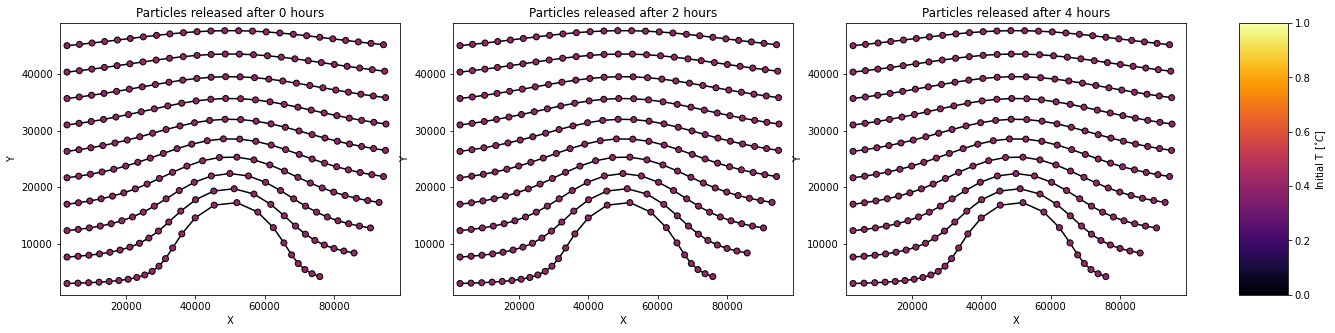

In [46]:
Particle_data = xr.open_dataset("RepeatLoop.nc")

Release0 = Particle_data.where(Particle_data.time[:,0]==np.timedelta64(0, 's'))
Release1 = Particle_data.where(Particle_data.time[:,0]==np.timedelta64(7200, 's'))
Release2 = Particle_data.where(Particle_data.time[:,0]==np.timedelta64(14400, 's'))

fig = plt.figure(figsize = (22,5))
gs = fig.add_gridspec(1,4,width_ratios=[7,7,7,1])

ax0 = fig.add_subplot(gs[0,0])
ax0.set_title('Particles released after 0 hours')
ax0.set_ylabel('Y')
ax0.set_xlabel('X')
ax0.set_ylim(1000, 49000)
ax0.set_xlim(1000, 99000)
ax0.plot(Release0.lon.transpose(), Release0.lat.transpose(), c='k', zorder=1)
T_scatter0 = ax0.scatter(Release0.lon, Release0.lat, 
                       c=np.tile(Release0.temperature, (Release0.lon.shape[1], 1)).T,
                       cmap=plt.cm.inferno, norm=mpl.colors.Normalize(vmin=0., vmax=1.), 
                       edgecolor='k', zorder=2)

ax1 = fig.add_subplot(gs[0,1])
ax1.set_title('Particles released after 2 hours')
ax1.set_ylabel('Y')
ax1.set_xlabel('X')
ax1.set_ylim(1000, 49000)
ax1.set_xlim(1000, 99000)
ax1.plot(Release1.lon.transpose(), Release1.lat.transpose(), c='k', zorder=1)
T_scatter1 = ax1.scatter(Release1.lon, Release1.lat, 
                       c=np.tile(Release1.temperature, (Release1.lon.shape[1], 1)).T,
                       cmap=plt.cm.inferno, norm=mpl.colors.Normalize(vmin=0., vmax=1.), 
                       edgecolor='k', zorder=2)

ax2 = fig.add_subplot(gs[0,2])
ax2.set_title('Particles released after 4 hours')
ax2.set_ylabel('Y')
ax2.set_xlabel('X')
ax2.set_ylim(1000, 49000)
ax2.set_xlim(1000, 99000)
ax2.plot(Release2.lon.transpose(), Release2.lat.transpose(), c='k', zorder=1)
T_scatter2 = ax2.scatter(Release2.lon, Release2.lat, 
                       c=np.tile(Release2.temperature, (Release2.lon.shape[1], 1)).T,
                       cmap=plt.cm.inferno, norm=mpl.colors.Normalize(vmin=0., vmax=1.), 
                       edgecolor='k', zorder=2)

ax3 = fig.add_subplot(gs[0,3])
plt.colorbar(T_scatter, cax = ax3, label='Initial T [$^{\circ} C$]',use_gridspec=True)
plt.show()